# This lab will present filter bank method for signal resampling and to resynthetise signal 

In [30]:
import scipy 
import time
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

### Signal Resampling

In [31]:
def load_sound(file):
    '''
    Load the audio file file
    '''
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    '''
    Plot the audio data within the timeframe time
    '''
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

In [32]:
data_path = os.getcwd()
filename = 'caravan_48khz.wav'
sound = os.path.join(data_path, filename) 
wavefile = load_sound(sound)
print(wavefile.getparams())

play = False
if play :
    play_sound(sound) 

Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)
print(len(x))

timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')
805733


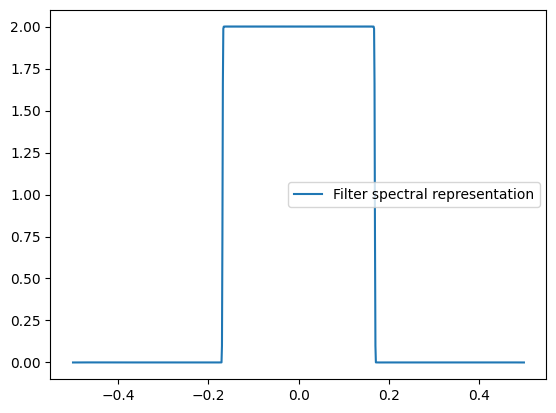

In [33]:
#Question 2
transition_width=200/Fs
L=2
M=3
nu_c=min(1/(2*M),1/(2*L))                           #Cut off frequency
N=1000                                              #length of H
n_comp=2                                            #number of polyphase component
def lowPass(N,nu_c=nu_c,transition_width=transition_width,L=L):
    return scipy.signal.remez(N,[0,nu_c,nu_c+transition_width,.5],[L,0])

H=np.fft.fftshift(np.fft.fft(lowPass(N),N))
nu=[i/N-1/2 for i in range(N)]
#plt.plot(nu,20*np.log(np.abs(H)))     
plt.plot(nu,np.abs(H), label = 'Filter spectral representation')
plt.legend()
plt.show()


In [34]:
#Question 3
def upSampling(x,L):
    ''' 
    Upsample the signal by factor L
    '''
    x_L=[0 for i in range(L*len(x))]
    for i in range(len(x)):
        x_L[L*i]=x[i]
    return x_L

def downSampling(x,M):
    ''' 
    Downsample the signal by a factor M
    '''
    x_M=[x[M*i] for i in range(len(x)//M)]
    return x_M

def changeSampling(x,L,M):
    '''
    Convert the sampling of a given signal by the ratio L/M
    '''
    x_L=upSampling(x,L)
    nu_c=min(1/(2*L),1/(2*M))
    x_truncated=scipy.signal.lfilter(lowPass(N,nu_c=nu_c),[1],x_L)
    return downSampling(x_truncated,M)
 


In [35]:
#Question 5
def polyphase_component(h,order):
    '''
    Compute polyphase component of order order for a filter h
    '''
    polyphase_list=[]
    for i in range(order):
        polyphase_list.append([h[order*j+i] for j in range(len(h)//order)])
    return polyphase_list

def shift(x,delay):
    '''
    Shift the representation of x given a delay delay
    '''
    return [x[(i+delay)%len(x)] for i in range(len(x))]

def transform(component,L,M):
    '''
    Resample a polyphase component by a factor L/M and shift the result temporaly by 1 (equivalent to multiply by a factor z in the spectral domain)
    '''
    w=shift(component,1)
    w=downSampling(w,M)
    w=upSampling(w,L)
    w=shift(w,-1)
    return w

def efficient_sampling(x,L,M,order):      #L and M need to be coprime
    '''Compute an efficient resampling by a factor L/M of the signal x using Noble identities on polyphase components'''
    h=lowPass(N,nu_c=min(1/(2*L),1/(2*M)))
    polyphase_comp=polyphase_component(h,order)
    x_resampled=np.zeros(int(len(x)*L/M)-1)
    for i in range(len(polyphase_comp)):
        x_resampled=np.add(x_resampled,transform(shift(scipy.signal.lfilter(b=polyphase_comp[i],a=[1],x=x),i),L,M)[:len(x_resampled)])    
    return x_resampled

In [36]:
#Question 6
#x=np.random.normal(size=10000)
t0=time.time()
x1=changeSampling(x,L,M)
t1=time.time()
t2=time.time()
x2=efficient_sampling(x,L,M,n_comp)
t3=time.time()
print('Computation time:',t1-t0,t3-t2)

Computation time: 0.42279887199401855 0.8151824474334717


In [37]:
write('new_caravan.wav', int(Fs*L/M), np.array(x1, dtype=np.int16)) 
write('new_caravanpolyphase.wav', int(Fs*L/M), np.array(x1, dtype=np.int16))  

### Signal synthesis

2 STFT Audio Equalization

2.1 STFT Analysis

1. We have
$$
w(n)=\frac 1 2 [1 - cos(\frac {2\pi n}{N_w})]
$$
$$
\hat{w}(\frac k M) = \sum_{k=0}^{N_w} w(n)e^{\frac {2j\pi k }{M}} = \sum_{k=0}^{N_w} \frac 1 4 [2 - (e^{\frac {2j\pi k }{N_w}} + e^{-\frac {2j\pi k }{N_w}})) e^{\frac {2j\pi k }{M}} = 
\frac 1 4 (2 \frac {1-e^{\frac {2j\pi (N_w+1) }{M}}}{1-e^{\frac {2j\pi }{M}}} - \frac {1-e^{\frac {2j\pi (M+N_w)(N_w+1) }{MN_w}}}{1-e^{\frac {2j\pi (M+N_w) }{MN_w}}} - \frac {1-e^{\frac {2j\pi (M-N_w-1) }{MN_w}}}{1-e^{\frac {-2j\pi (M+N_w) }{MN_w}}})
$$
$$
\hat{w}(\frac k M)= \frac 1 4 e^{\frac {j\pi N_w}{M}}(2 \frac {sin(\frac {\pi N_w+1}{M})}{sin(\frac {\pi}{M})} -e^{\frac {j\pi }{M}} \frac {sin(\frac {\pi (M+N_w)(N_w+1)}{MN_w})}{sin(\frac {\pi (M+N_w) }{MN_w})} - e^{-\frac {j\pi }{M}} \frac {sin(\frac {\pi (M-N_w-1)(N_w+1)}{MN_w})}{sin(\frac {\pi(M-N_w) }{MN_w})} )
$$
The length of the main lobe is $\frac {8\pi}{N_w}$

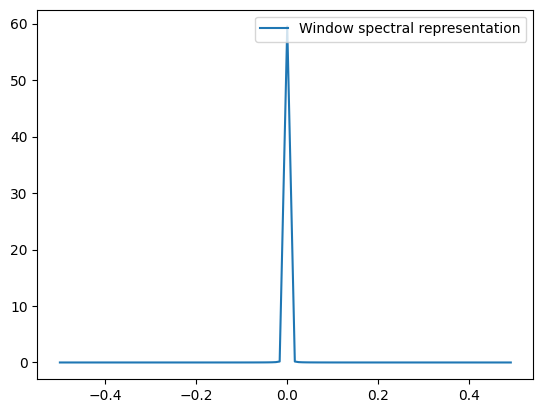

In [38]:
#2.1.1
N_w=120
w=np.hanning(N_w)
k=2
W= np.fft.fft(w,N_w)
W=np.fft.fftshift(W)
nu=[i/N_w-1/2 for i in range(N_w)]
plt.plot(nu,np.abs(W), label= 'Window spectral representation')
plt.legend()
plt.show()

2.We have $W_x(\lambda,b)=(x*h_{\lambda})(b)$ with $h_{\lambda}[n]= w[-n]e^{j2\pi \lambda n}=w[n]e^{j2\pi \lambda n}$ because we have w symmetric

We deduce from the previous expression $H_{\lambda}(z)=W(z-\lambda)$

So for ${\lambda}$ close to 0, h is a low-pass filter and for ${\lambda}$ close to $\frac 1 2$, h is a high-pass filter

We also have that, if h is real (condition of FIR filter) $\quad h[N_w-n]=w[N_w-n]=\frac 1 2 [1 - cos(\frac {2\pi (N_w-n)}{N_w})] = \frac 1 2 [1 - cos(\frac {2\pi (n)}{N_w})]=h[n]$ so h is symmetric.

We deduce h is type II if $N_w$ is even ,type I otherwise

3 .$\tilde{X}(\lambda,b)= e^{-j2\pi b} W_x(\lambda,b)$

According to https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html , the stft is implemented with $W_x$

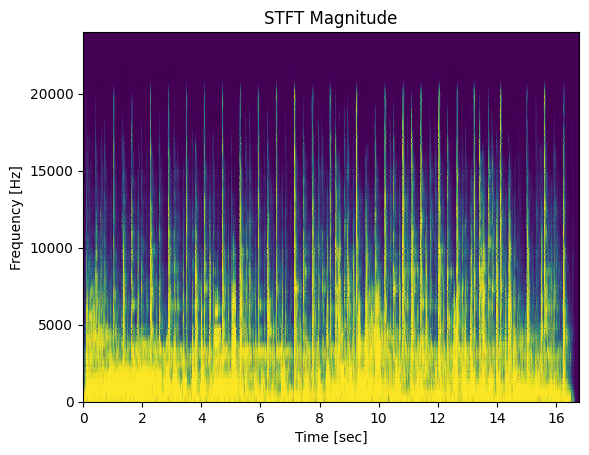

In [39]:
#Question 4
M=32
k=3
f,t,Zxx=scipy.signal.stft(x,fs=48000,nperseg=120)
x_k=np.zeros(len(t),dtype=complex)
for u in range(len(t)):
    x_k[u]=np.exp((1j*np.pi*k*u)/M)*Zxx[k][u]


write('new_caravanreal.wav', Fs, np.array(x_k.real, dtype=np.int16))

plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=100, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()



The output signal is complex for k=3

To show that a sufficient perfect reconstruction condition is $\forall n f(n)=1$, we need to compute $y(n)=\frac 1 M \sum_{u \in \mathbb{Z}}\sum_{l \in \mathbb{Z}} \sum_{k=0}^{M} w_s(n-uR)x(l+uR)w(l)e^{\frac {j2\pi(k(n-uR-l))}{M}}$ 

If we suppose f(n) = 1 then, if we notice that the only component depending on k in the sum is the term in exponential, the sums cancels if n-uR-l is not 0 : 

$$y(n)=\frac 1 M \sum_{u \in \mathbb{Z}}\sum_{l \in \mathbb{Z}}  w_s(n-uR)x(l+uR)w(l)M \mathbb{1}_{l=n-uR}= \sum_{u \in \mathbb{Z}} w_s(n-uR)x(n)w(n-uR)=x(n)f(n)=x(n) $$ 


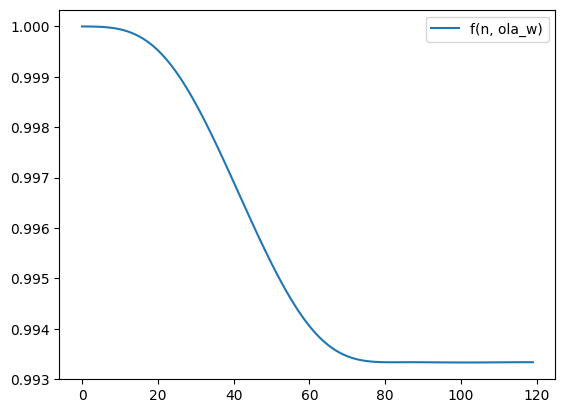

In [40]:
#Question 5

def ola(w = None,hop = None,Nb = 10): 
    '''
    Realize an add-overlap over a window w , a shift hop and a number of window Nb
    '''
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # reserve memory space
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output


Nb=10
w_p=np.array([y*y for y in w])
w_p=np.array([4/Nb*y/sum(w_p) for y in w_p])
ola_w=ola(w_p,len(w_p)//4,Nb)
def f(n,ola_w):
    return np.sum([ola_w[n-4*u][0] for u in range(len(ola_w)//4)])

plt.plot(np.array([f(n,ola_w) for n in range(len(w))]),label='f(n, ola_w)')
plt.legend()
plt.show()


In [41]:
#Question 6


def resynthesis(x):
    ''' Resynthetise the signal x '''
    y=np.zeros(len(x))
    Nb=10
    w_s=np.array([1/np.sqrt(Nb)*y/np.sum([y*y for y in w]) for y in w])
    ola_w=ola(w_s,int(len(w_s)/4),Nb)                     #here since w_s = w i use w_s to also denote w normalized
    for n in range(len(y)):
        y[n]=f(n%len(w_s),ola_w)*x[n]
    return y

y=(resynthesis(x))                              #Need to wait some seconds

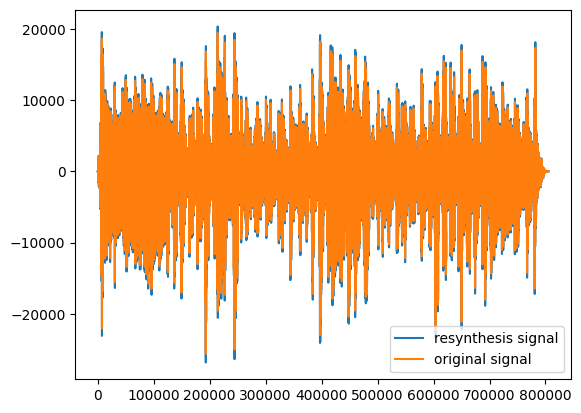

In [42]:
plt.plot(y , label = 'resynthesis signal')    
plt.plot(x, label='original signal')   
plt.legend()
plt.show()

It seems like the reconstruction is very close to the original signal according to the plot above.

In [43]:
#Question 7 
def equalizer(x,y):
    norm1_x=np.sum([np.abs(l) for l in x])
    return np.sum([np.abs(y[n]-x[n])/norm1_x for n in range(len(x))])

print('Signal difference :',equalizer(x,y))

Signal difference : 0.04952694888060185
